# Training

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
import tqdm

import matplotlib.pyplot as plt

In [2]:
from src.starcattovae.training.data import Data, DataLoader
from src.starcattovae.nn.decoder import Decoder
from src.starcattovae.nn.encoder import Encoder
from src.starcattovae.nn.model import Model

In [3]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

### Define Parameters

In [4]:
# configure parameters
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 320

x_dim = 256
hidden_dim = 512
latent_dim = 64
lr = 1e-3

Using device: mps


## Load Training Data

In [5]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

# Create train and test datasets
train_dataset = Data(indices=train_indices, train=True)
test_dataset = Data(indices=test_indices, train=False)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
test_indices_set = set(test_dataset.get_indices())

overlap = train_indices_set.intersection(test_indices_set)
if len(overlap) == 0:
    print("Train and test sets are different.")
else:
    print("Train and test sets have overlap.")

Train and test sets are different.


In [6]:
train_dataset.summary()
test_dataset.summary()

2024-11-12 00:29:02.963 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)

2024-11-12 00:29:02.964 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)



In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Load Autoencoders

In [8]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder, DEVICE=DEVICE).to(DEVICE)

### Loss Function

In [9]:
def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

### Train VAE

Start training VAE...
Epoch 1 complete! 	Average Loss: 0.9652
Epoch 2 complete! 	Average Loss: 0.6867
Epoch 3 complete! 	Average Loss: 0.6678
Epoch 4 complete! 	Average Loss: 0.6687
Epoch 5 complete! 	Average Loss: 0.6662
Epoch 6 complete! 	Average Loss: 0.6586
Epoch 7 complete! 	Average Loss: 0.6594
Epoch 8 complete! 	Average Loss: 0.6545
Epoch 9 complete! 	Average Loss: 0.6522
Epoch 10 complete! 	Average Loss: 0.6488


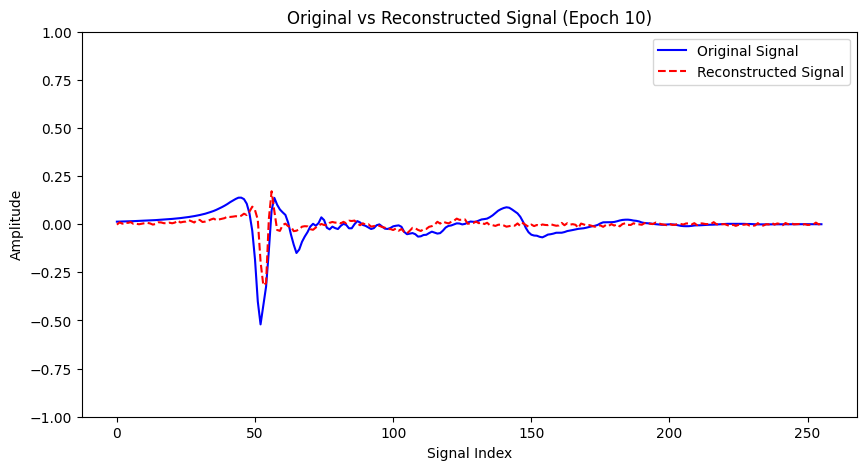

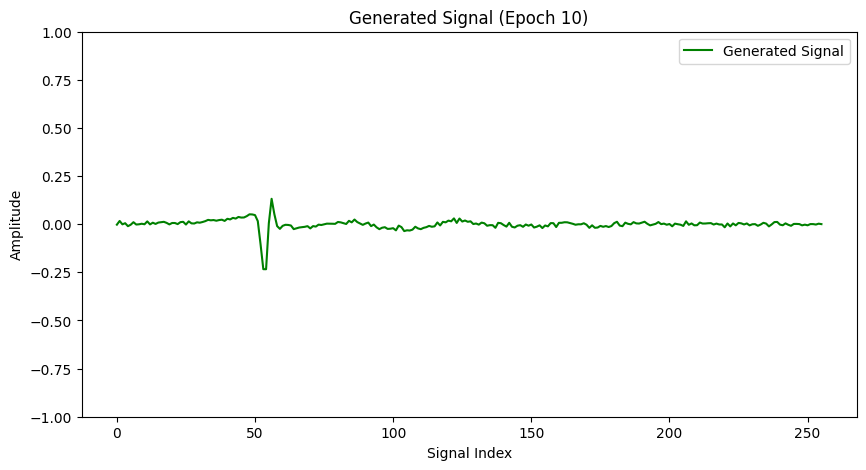

Epoch 11 complete! 	Average Loss: 0.6447
Epoch 12 complete! 	Average Loss: 0.6409
Epoch 13 complete! 	Average Loss: 0.6436
Epoch 14 complete! 	Average Loss: 0.6458


In [10]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    total_samples = 0

    for batch_idx, x in enumerate(train_dataloader, 0):
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        total_samples += x.size(0)

        loss.backward()
        optimizer.step()

    avg_loss = overall_loss / total_samples
    print(f"Epoch {epoch + 1} complete! \tAverage Loss: {avg_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        # After each epoch, plot the original and reconstructed signal for the first batch
        x = x.cpu().detach().numpy()
        x_hat = x_hat.cpu().detach().numpy()

        plt.figure(figsize=(10, 5))
        plt.plot(x[0], label="Original Signal", color='blue')
        plt.plot(x_hat[0], label="Reconstructed Signal", color='red', linestyle='dashed')

        plt.title(f"Original vs Reconstructed Signal (Epoch {epoch + 1})")
        plt.xlabel("Signal Index")
        plt.ylabel("Amplitude")
        plt.ylim(-1, 1)
        plt.legend()
        plt.show()

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            noise = torch.randn(batch_size, latent_dim).to(DEVICE)
            generated_signals = decoder(noise).cpu().detach().numpy()

            plt.figure(figsize=(10, 5))
            plt.plot(generated_signals[0], label="Generated Signal", color='green')
            plt.title(f"Generated Signal (Epoch {epoch + 1})")
            plt.xlabel("Signal Index")
            plt.ylabel("Amplitude")
            plt.ylim(-1, 1)
            plt.legend()
            plt.show()

print("Training finished!")

print("Training finished!")


### Test Generated Signals

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, x in enumerate(test_dataloader, 0):
        x = x.view(x.size(0), -1)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

In [ ]:
x_hat

tensor([[0.0661, 0.0527, 0.0630,  ..., 0.1234, 0.0655, 0.0336],
        [0.0572, 0.1054, 0.0711,  ..., 0.3051, 0.0926, 0.0453],
        [0.0395, 0.0440, 0.0502,  ..., 0.1177, 0.0706, 0.0259],
        ...,
        [0.1070, 0.1135, 0.0829,  ..., 0.2631, 0.1633, 0.0521],
        [0.0267, 0.0639, 0.0506,  ..., 0.1836, 0.0783, 0.0286],
        [0.0694, 0.0507, 0.0341,  ..., 0.1924, 0.1557, 0.0495]],
       device='mps:0')